In [84]:
import yaml
with open('config.yaml', 'r') as config:
    cfg = yaml.safe_load(config)

In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [86]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [87]:
df = pd.read_csv(cfg["dataset"])[:10**6]

In [4]:
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [88]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

In [5]:
df_train.columns, df_train.shape[0]

(Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
        'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
        'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
        'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
        'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
        'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
        'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
        'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
        'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
        'Astronomical_Twilight'],
       dtype='object'),
 6182715)

In [89]:
df_train.isna().sum().sort_values(ascending=False)

End_Lat                  800000
End_Lng                  800000
Precipitation(in)        380095
Wind_Chill(F)            368432
Wind_Speed(mph)           80220
Visibility(mi)            15136
Weather_Condition         14507
Humidity(%)               13224
Temperature(F)            12206
Wind_Direction            10797
Pressure(in)               9865
Weather_Timestamp          7902
Street                     1374
Nautical_Twilight          1349
Civil_Twilight             1349
Sunrise_Sunset             1349
Astronomical_Twilight      1349
Airport_Code               1151
Timezone                    360
Zipcode                     110
City                         24
Description                   1
No_Exit                       0
Severity                      0
Start_Time                    0
End_Time                      0
Turning_Loop                  0
Traffic_Signal                0
Traffic_Calming               0
Stop                          0
Station                       0
Roundabo

(0.9999934274298031, 0.9999987660494893)

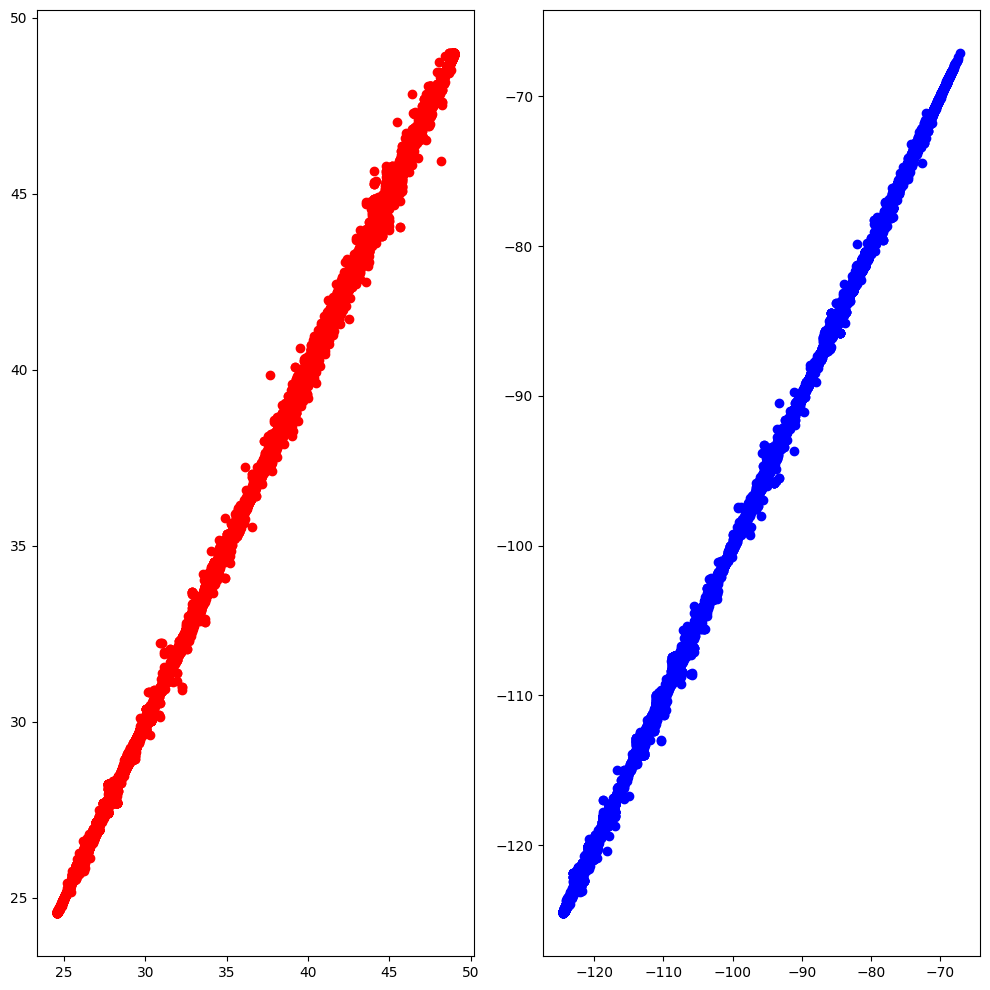

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
df_cor = df_train[['Start_Lat', 'End_Lat', 'Start_Lng', 'End_Lng']]
df_cor.dropna()
axes[0].plot(df_cor['Start_Lat'], df_cor['End_Lat'], 'ro', linestyle="None")
axes[1].plot(df_cor['Start_Lng'], df_cor['End_Lng'], 'bo', linestyle="None")
fig.tight_layout()

df_train['Start_Lat'].corr(df_train['End_Lat']), df_train['Start_Lng'].corr(df_train['End_Lng'])

In [91]:
def add_column_mean_coordinate(start: pd.Series, end: pd.Series) -> pd.Series:
    fill_end = end.fillna(start)
    new_series = (start + fill_end) / 2
    return new_series
 
df_train['Lat'] = add_column_mean_coordinate(df_train['Start_Lat'], df_train['End_Lat'])
df_train['Lng'] = add_column_mean_coordinate(df_train['Start_Lng'], df_train['End_Lng'])

# df_train.drop(columns=['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng'], inplace=True)

In [93]:
nan_df = (df_train.isnull().mean() * 100).reset_index()
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)
nan_df.head(10)

,column_name,percentage
21,Precipitation(in),47.511875
15,Wind_Chill(F),46.054000
20,Wind_Speed(mph),10.027500
18,Visibility(mi),1.892000
22,Weather_Condition,1.813375
16,Humidity(%),1.653000
14,Temperature(F),1.525750
19,Wind_Direction,1.349625
17,Pressure(in),1.233125
13,Weather_Timestamp,0.987750


In [92]:
df_train.drop(columns=['ID', 'Source', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng'], inplace=True)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6182715 entries, 7301655 to 4500015
Data columns (total 42 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Severity               int64  
 1   Start_Time             object 
 2   End_Time               object 
 3   Distance(mi)           float64
 4   Description            object 
 5   Street                 object 
 6   City                   object 
 7   County                 object 
 8   State                  object 
 9   Zipcode                object 
 10  Country                object 
 11  Timezone               object 
 12  Airport_Code           object 
 13  Weather_Timestamp      object 
 14  Temperature(F)         float64
 15  Wind_Chill(F)          float64
 16  Humidity(%)            float64
 17  Pressure(in)           float64
 18  Visibility(mi)         float64
 19  Wind_Direction         object 
 20  Wind_Speed(mph)        float64
 21  Precipitation(in)      float64
 22  Weather_Condition

In [94]:
num_df = df_train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
bool_df = df_train.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object'])
cat_df = df_train.select_dtypes(include=['object'])
len(num_df.columns), len(bool_df.columns), len(cat_df.columns)

(11, 13, 18)

In [11]:
num_df.columns, bool_df.columns, cat_df.columns

(Index(['Severity', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)',
        'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
        'Precipitation(in)', 'Lat', 'Lng'],
       dtype='object'),
 Index(['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
        'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
        'Traffic_Signal', 'Turning_Loop'],
       dtype='object'),
 Index(['Start_Time', 'End_Time', 'Description', 'Street', 'City', 'County',
        'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
        'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition',
        'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
        'Astronomical_Twilight'],
       dtype='object'))

Заметим, что булевые признаки, кроме Amenity показывают на то, где произошло ДТП:
"Отбойник", "Перекресток", "Уступка", "Развязка", "Запретный выезд", "Железная дорога", "Кольцевая развязка", "Станция", "Остановка", "Регулировка движения", "Дорожный сигнал", "Поворотная петля"


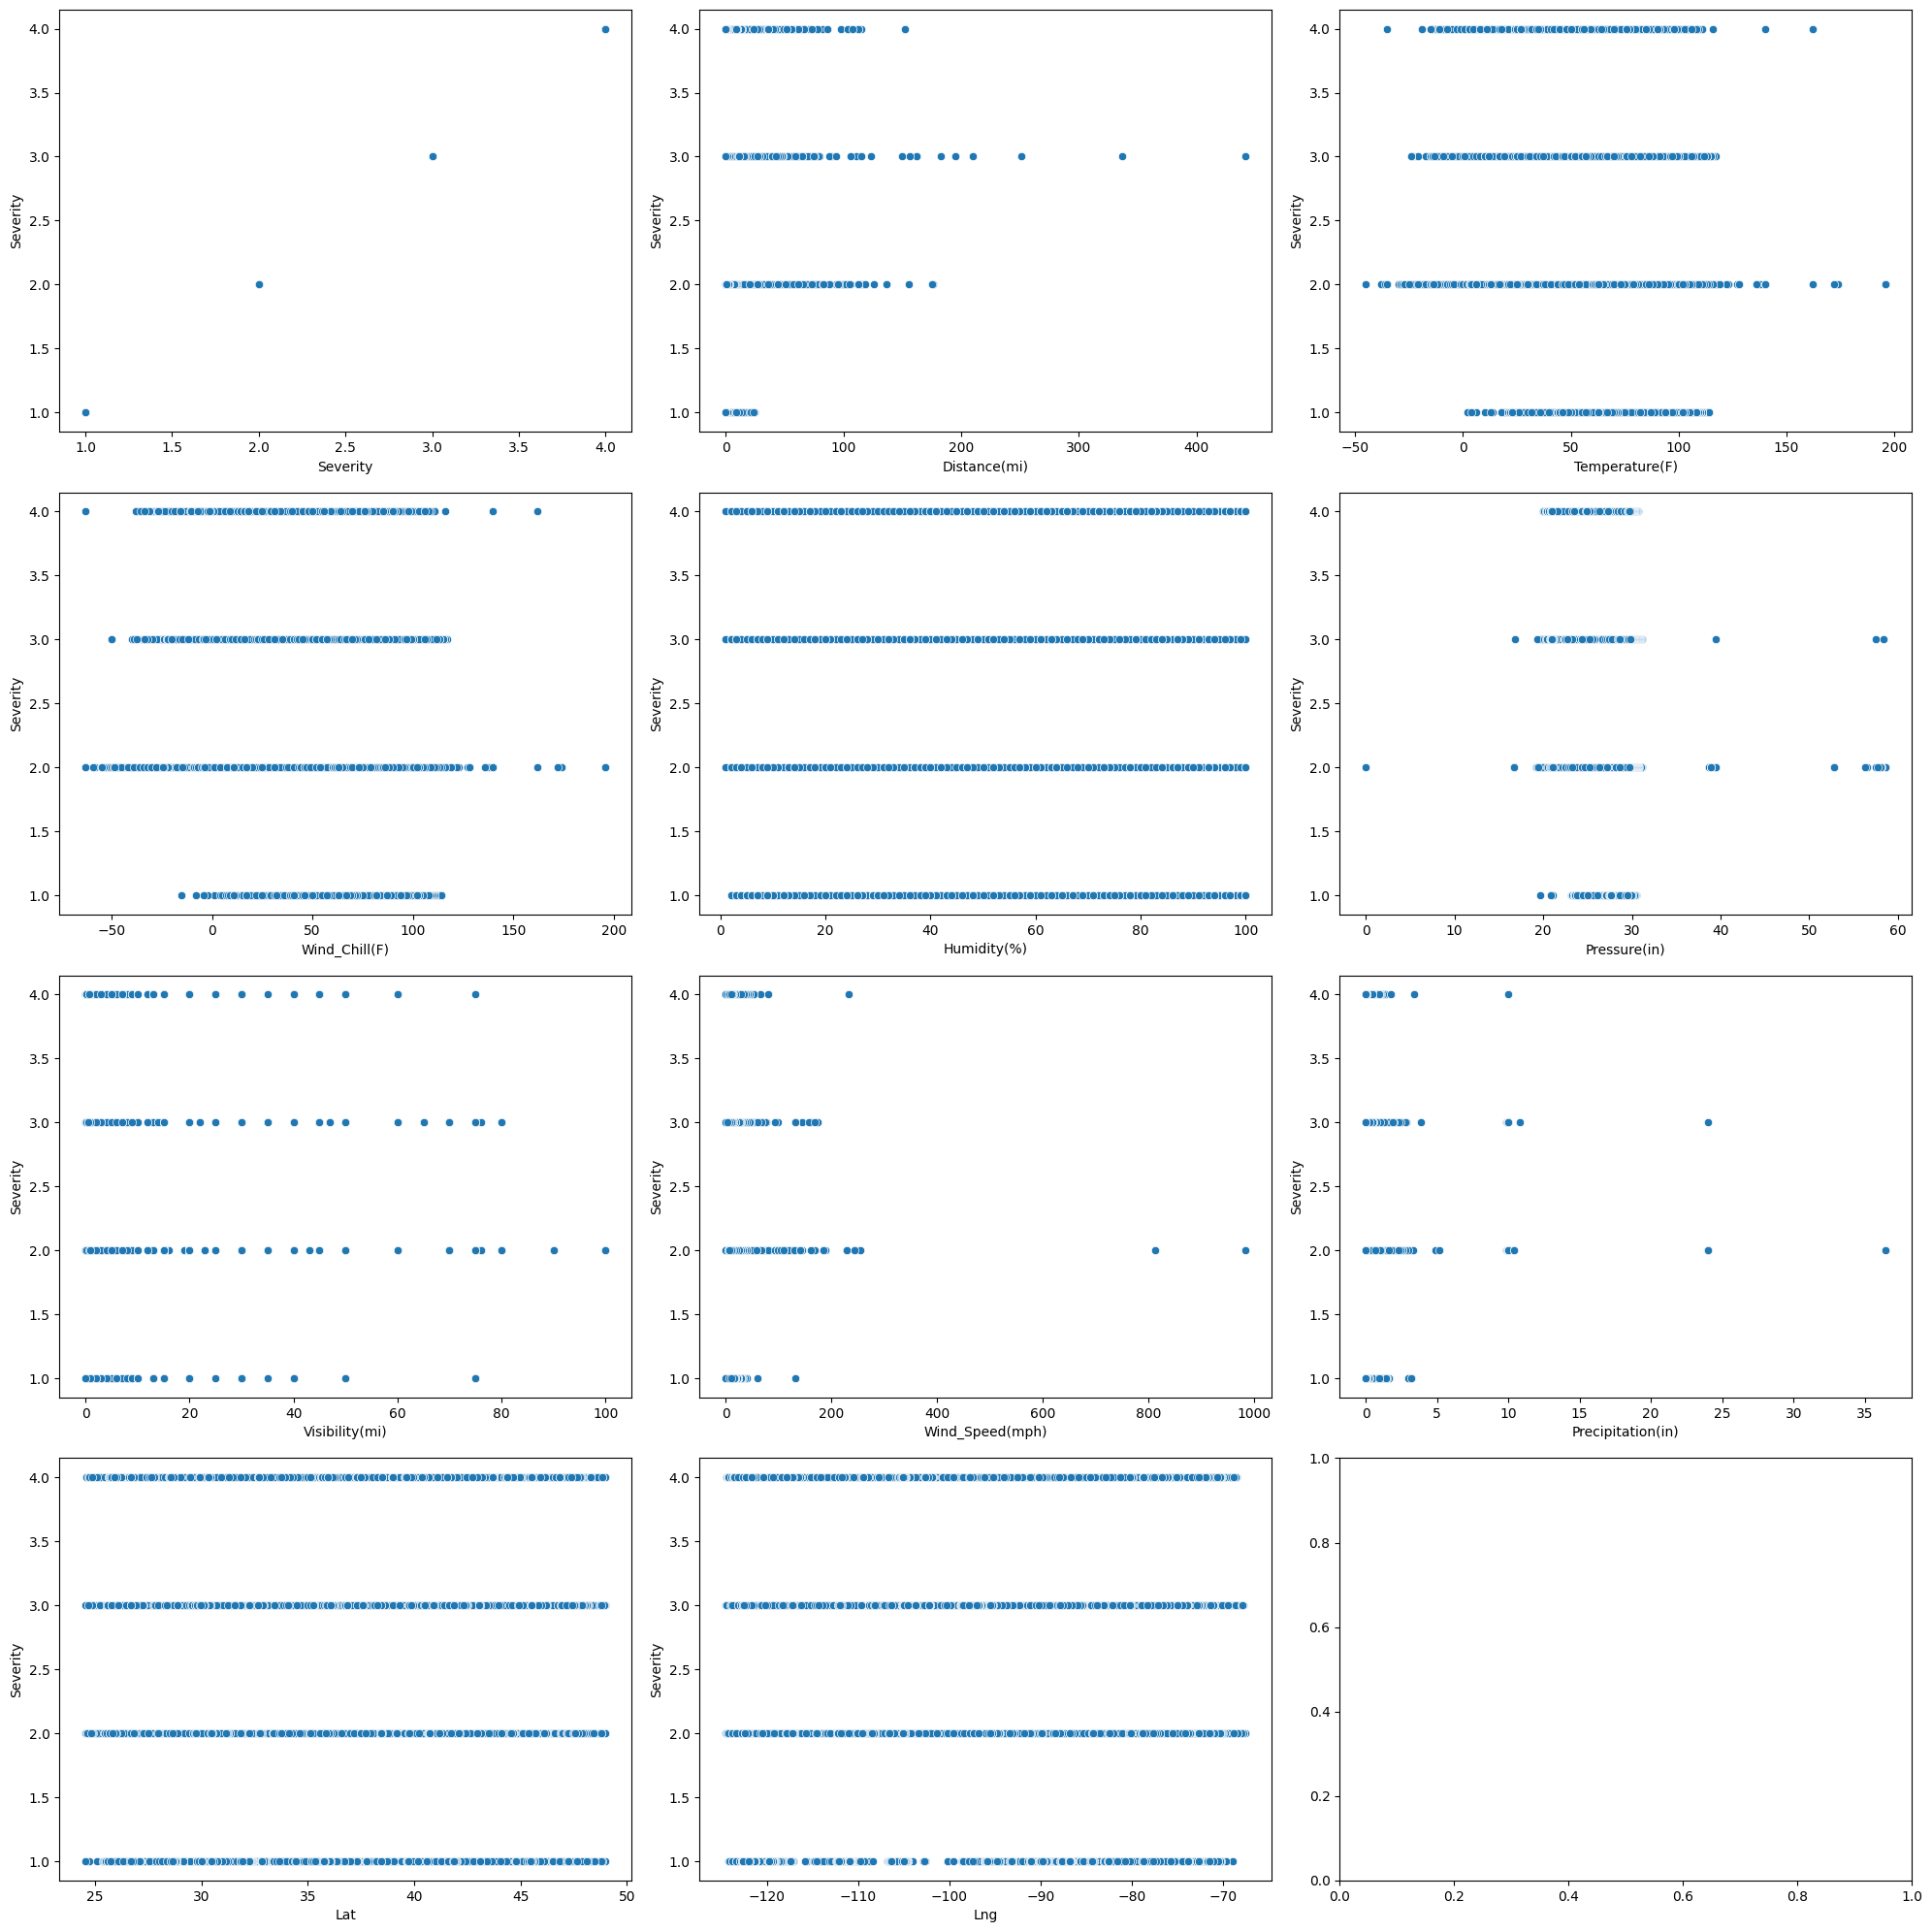

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes_flattened = axes.reshape(-1)

for i in range(len(num_df.columns)):
    ax = axes_flattened[i]
    sns.scatterplot(
        x=num_df.iloc[:, i],
        y='Severity',
        data=num_df.dropna(),
        ax=ax,
    )
fig.tight_layout(pad=1.0)

In [14]:
num_df.describe()

,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Lat,Lng
count,6.182715e+06,6.182715e+06,6.051672e+06,4.583364e+06,6.043395e+06,6.070063e+06,6.041108e+06,5.725806e+06,4.419735e+06,6.182715e+06,6.182715e+06
mean,2.212391e+00,5.614313e-01,6.166398e+01,5.824878e+01,6.483113e+01,2.953923e+01,9.090378e+00,7.686010e+00,8.390512e-03,3.620039e+01,-9.470231e+01
std,4.874937e-01,1.776407e+00,1.901473e+01,2.239041e+01,2.281816e+01,1.006013e+00,2.686315e+00,5.405675e+00,1.105884e-01,5.076348e+00,1.739230e+01
min,1.000000e+00,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.455480e+01,-1.246238e+02
25%,2.000000e+00,0.000000e+00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00,3.339939e+01,-1.172193e+02
50%,2.000000e+00,3.000000e-02,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00,3.582415e+01,-8.776408e+01
75%,2.000000e+00,4.640000e-01,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00,4.008427e+01,-8.035368e+01
max,4.000000e+00,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,9.840000e+02,3.647000e+01,4.900220e+01,-6.711120e+01


In [56]:
def corrplot(df_corr, method="pearson", annot=True, **kwargs):
    df_corr = df_corr.dropna()
    matrix_corr = df_corr.corr(method)
    print(type(matrix_corr))
    sns.clustermap(
        df_corr.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )
    return matrix_corr

<class 'pandas.core.frame.DataFrame'>


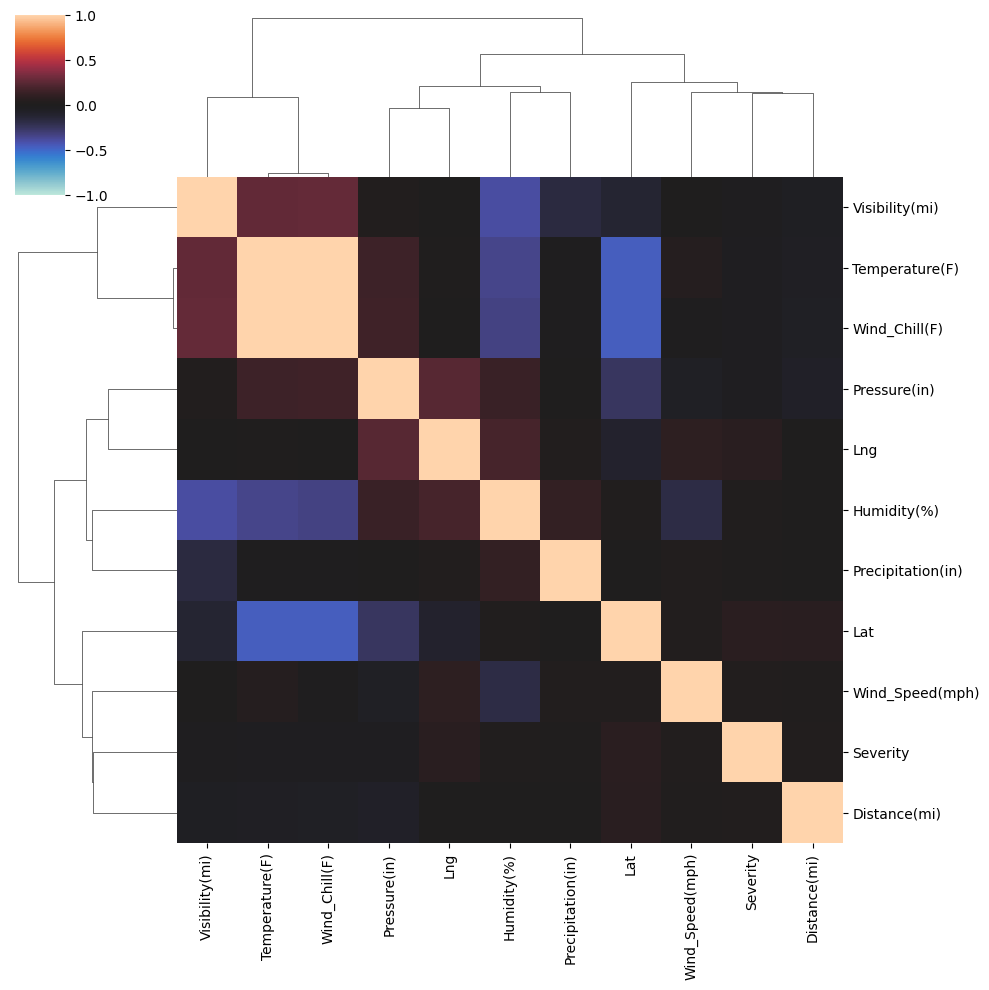

In [15]:
matrix_corr = corrplot(num_df, annot=None)

In [16]:
matrix_corr

,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Lat,Lng
Severity,1.000000,0.029747,-0.025052,-0.028064,0.021290,-0.031127,-0.019005,0.024000,0.015151,0.076526,0.068725
Distance(mi),0.029747,1.000000,-0.054347,-0.058880,0.007492,-0.072099,-0.042782,0.021452,0.004020,0.065960,-0.005303
Temperature(F),-0.025052,-0.054347,1.000000,0.993646,-0.347252,0.151762,0.268125,0.040834,-0.010702,-0.461462,0.015085
Wind_Chill(F),-0.028064,-0.058880,0.993646,1.000000,-0.331130,0.159802,0.274475,-0.014781,-0.010720,-0.465851,0.000591
Humidity(%),0.021290,0.007492,-0.347252,-0.331130,1.000000,0.138567,-0.397960,-0.179816,0.109853,0.017472,0.180649
Pressure(in),-0.031127,-0.072099,0.151762,0.159802,0.138567,1.000000,0.025650,-0.055463,0.006397,-0.253955,0.235466
Visibility(mi),-0.019005,-0.042782,0.268125,0.274475,-0.397960,0.025650,1.000000,0.000497,-0.168336,-0.123566,-0.005358
Wind_Speed(mph),0.024000,0.021452,0.040834,-0.014781,-0.179816,-0.055463,0.000497,1.000000,0.031088,0.028390,0.087649
Precipitation(in),0.015151,0.004020,-0.010702,-0.010720,0.109853,0.006397,-0.168336,0.031088,1.000000,-0.006647,0.028942
Lat,0.076526,0.065960,-0.461462,-0.465851,0.017472,-0.253955,-0.123566,0.028390,-0.006647,1.000000,-0.096907


In [95]:
df_train.drop(columns=['Wind_Chill(F)'], inplace=True)
num_df.drop(columns=['Wind_Chill(F)'], inplace=True)

In [100]:
nan_df = (df_train.isnull().mean() * 100).reset_index()
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)

In [101]:
nan_df.head(20)

,column_name,percentage
21,Weather_Condition,1.813375
18,Wind_Direction,1.349625
13,Weather_Timestamp,0.987750
5,Street,0.171750
36,Civil_Twilight,0.168625
38,Astronomical_Twilight,0.168625
35,Sunrise_Sunset,0.168625
37,Nautical_Twilight,0.168625
12,Airport_Code,0.143875
11,Timezone,0.045000


In [98]:
nan_num_column = ['Wind_Speed(mph)', #mean
                  'Visibility(mi)', #mean
                  'Humidity(%)', #mean
                  'Temperature(F)', #mean
                  'Pressure(in)', #mean
                  'Precipitation(in)' #mean
                  ]

In [99]:
for using_column in nan_num_column:
    df_train[using_column] = df_train.groupby('Severity')[using_column].transform(lambda x: x.fillna(x.mean()))

In [58]:
using_column = nan_num_column[5]

In [59]:
df_train[using_column].median(), df_train[using_column].mean()

(0.0, 0.008259418230526602)

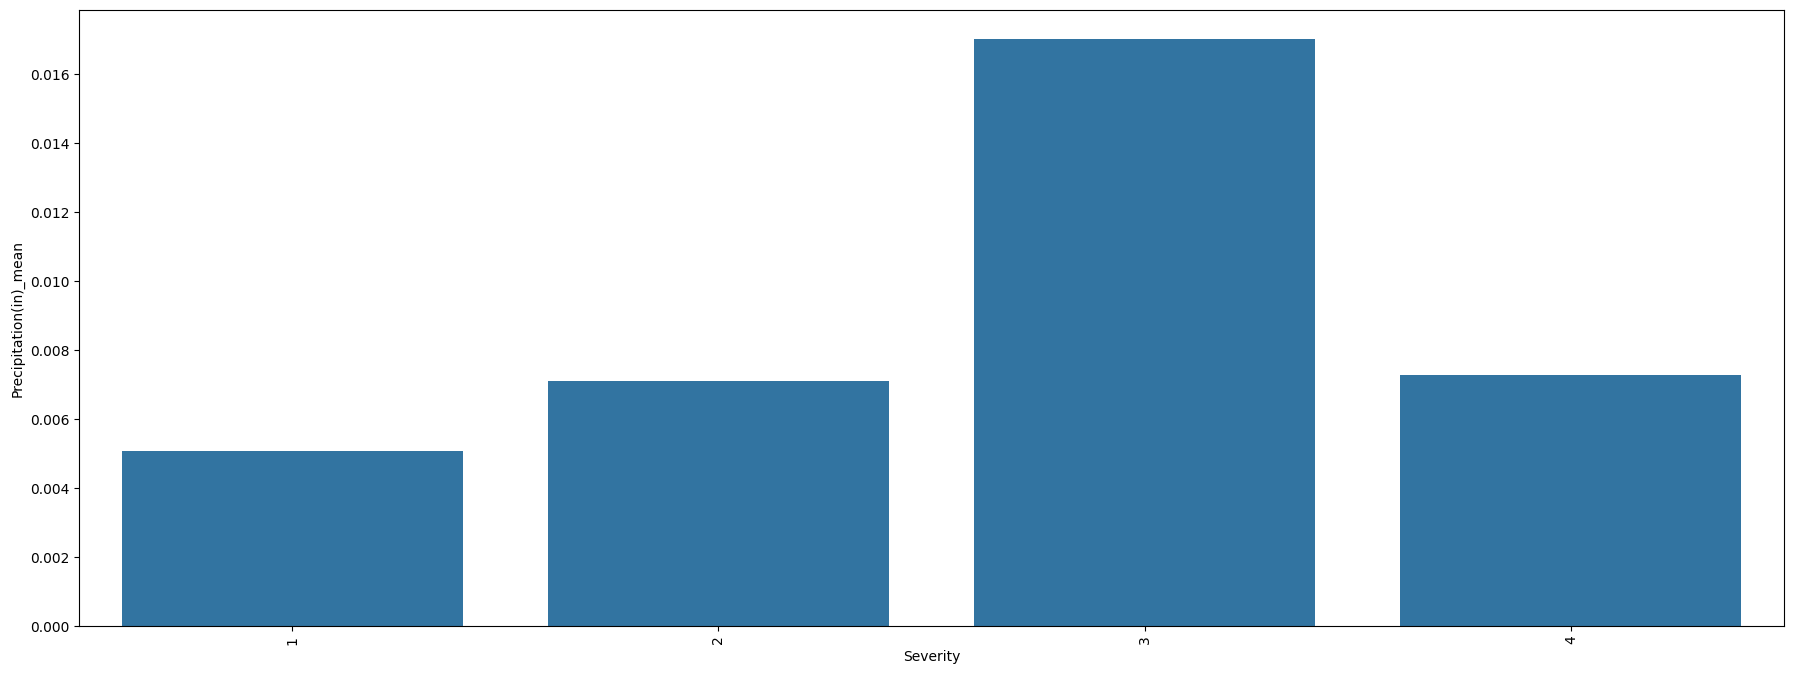

In [60]:
Severity_grouped = df_train.groupby('Severity')
Severity_lot = (
    Severity_grouped[using_column].mean()
    .reset_index(name=f"{using_column}_mean")
)

fig, axes = plt.subplots(1, 1, figsize=(22, 8))
axes.tick_params(axis='x', rotation=90)
sns.barplot(x='Severity', y=f"{using_column}_mean", data=Severity_lot, ax=axes)
plt.show()

In [61]:
df_train[using_column] = df_train.groupby('Severity')[using_column].transform(lambda x: x.fillna(x.mean()))

# Удаление столбцов с почти одними и теми же значениями

In [11]:
def get_almost_constant_columns(df: pd.DataFrame, dropna=True, limit: int = 96):
    cols = []
    for i in df:
        if dropna:
            counts = df[i].dropna().value_counts()
        else:
            counts = df[i].value_counts()
        most_popular_value_count = counts.iloc[0]
        if (most_popular_value_count / len(df)) * 100 - limit > 0:
            cols.append(i)
    return cols


In [12]:
overfit_cat = get_almost_constant_columns(cat_df, limit=96)
overfit_cat

['Country']

In [102]:
df_train.drop(columns=["Country"], inplace=True)

In [22]:
overfit_num = get_almost_constant_columns(num_df, dropna=True, limit=96)
overfit_num

[]

In [44]:
overfit_bool = get_almost_constant_columns(bool_df, dropna=True, limit=99)
overfit_bool

['Bump',
 'Give_Way',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Traffic_Calming',
 'Turning_Loop']

In [31]:
df_train.columns

Index(['Severity', 'Start_Time', 'End_Time', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Lat', 'Lng'],
      dtype='object')

# Удаление выбросов

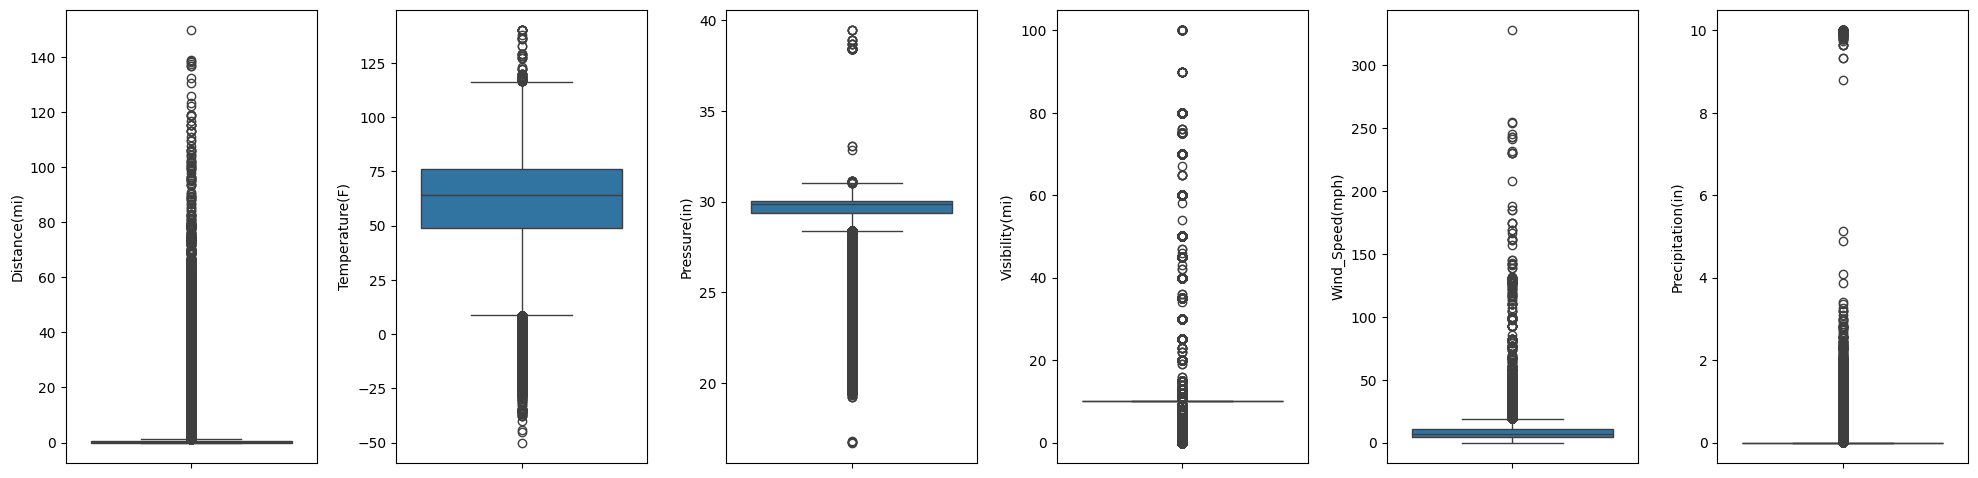

In [48]:
out_col = ["Distance(mi)", "Temperature(F)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]

fig, axes = plt.subplots(1, 6, figsize=(20, 5))
for ax, col in zip(axes, out_col):
    sns.boxplot(y=df_train[col], data=df_train, ax=ax)
fig.tight_layout(pad=1.5)

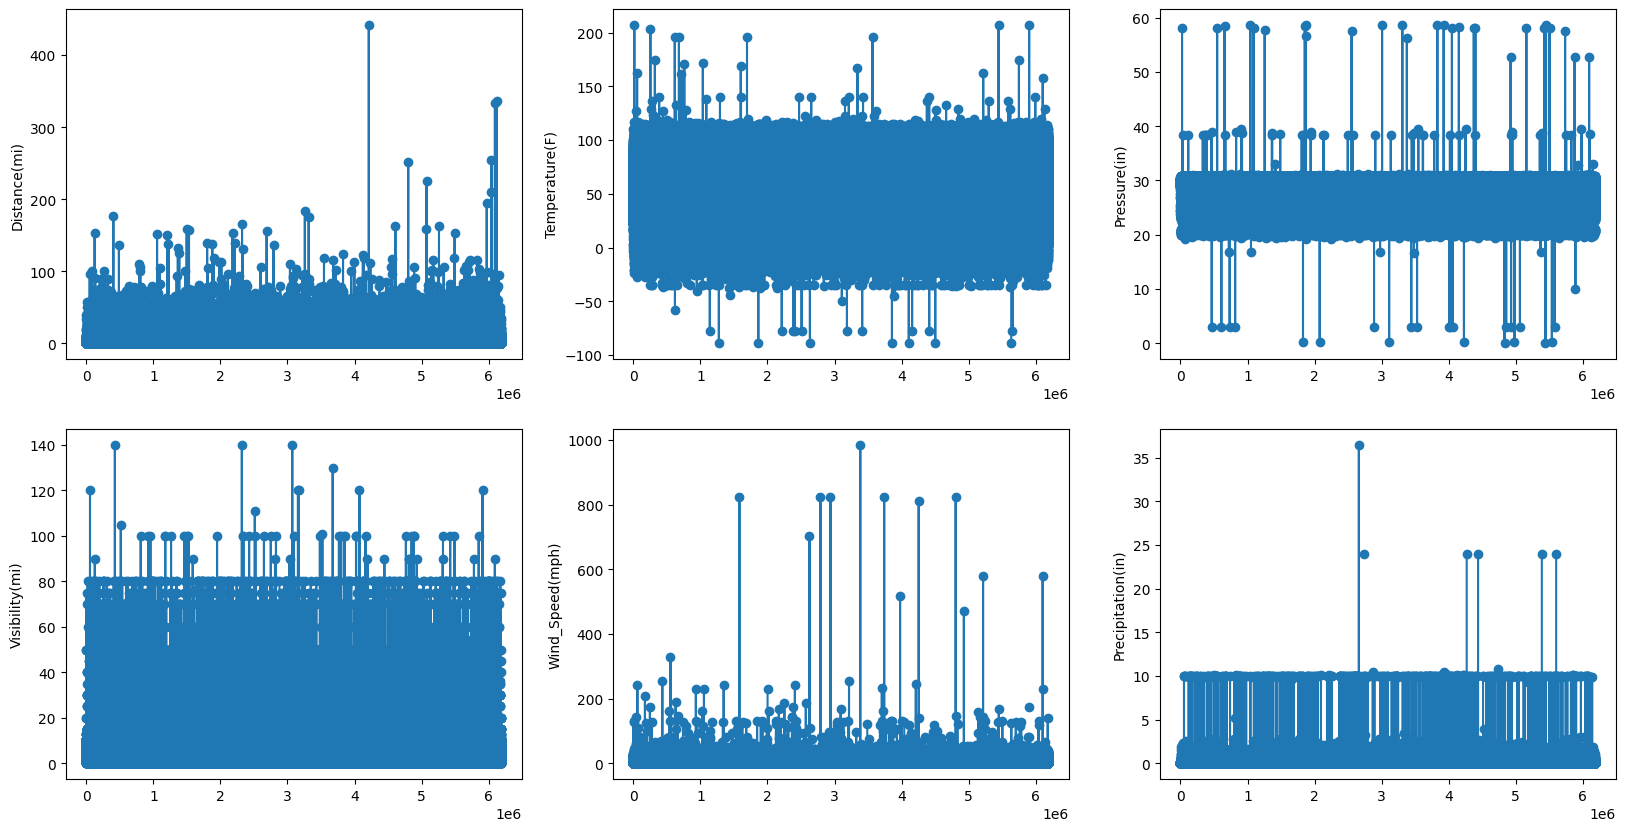

In [ ]:
out_col = ["Distance(mi)", "Temperature(F)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes_flattened = axes.flatten()

for index, column in enumerate(out_col):
    axes[index // 3][index % 3].plot(
        [i + 1 for i in range(len(df_train[column]))],
        df_train[column],
        marker='o'
    )
    axes[index // 3][index % 3].set_ylabel(column)

In [103]:
for col, upper_bound, down_bound in (
    ('Distance(mi)', 150, -150),
    ('Temperature(F)', 150, -50),
    ('Pressure(in)', 50, 10),
    ('Visibility(mi)', 100, -100),
    ('Wind_Speed(mph)', 400, -400),
    ("Precipitation(in)",10, -15),
):
    df_train = df_train.drop(df_train[df_train[col] > upper_bound].index)
    df_train = df_train.drop(df_train[df_train[col] < down_bound].index)

# Работа с категориальными признаками

In [104]:
df_train['Start_Time'] = pd.to_datetime(df_train['Start_Time'], format='mixed').dt.round("S")
df_train['End_Time'] = pd.to_datetime(df_train['End_Time'], format='mixed').dt.round("S")
df_train['Weather_Timestamp'] = pd.to_datetime(df_train['Weather_Timestamp'], format='mixed').dt.round("S")

In [105]:
Time_Mean = (df_train['Start_Time'] + (df_train['End_Time'] - df_train['Start_Time']) / 2)
df_train.loc[df_train['Weather_Timestamp'].isna(), 'Weather_Timestamp'] = Time_Mean.loc[df_train['Weather_Timestamp'].isna()]

In [106]:
df_train['Start_Date_Year'] = df_train['Start_Time'].dt.year
df_train['Start_Date_Month'] = df_train['Start_Time'].dt.month
df_train['Start_Date_Day'] = df_train['Start_Time'].dt.day
df_train['Start_Date_Hour'] = df_train['Start_Time'].dt.hour

df_train['End_Date_Year'] = df_train['End_Time'].dt.year
df_train['End_Date_Month'] = df_train['End_Time'].dt.month
df_train['End_Date_Day'] = df_train['End_Time'].dt.day
df_train['End_Date_Hour'] = df_train['End_Time'].dt.hour

df_train['Weather_Datestamp_Year'] = df_train['Weather_Timestamp'].dt.year
df_train['Weather_Datestamp_Month'] = df_train['Weather_Timestamp'].dt.month
df_train['Weather_Datestamp_Day'] = df_train['Weather_Timestamp'].dt.day
df_train['Weather_Datestamp_Hour'] = df_train['Weather_Timestamp'].dt.hour

In [107]:
df_train['Time_Difference'] = round((df_train['End_Time'] - df_train['Start_Time']).dt.total_seconds() / 60)

In [108]:
df_train.drop(columns=['Weather_Timestamp', 'Start_Time', 'End_Time'], inplace=True)

In [34]:
cat_df.head()

,Start_Time,End_Time,Description,Street,City,County,State,Zipcode,Timezone,Airport_Code,Weather_Timestamp,Wind_Direction,Weather_Condition,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
7301655,2019-10-22 13:43:00,2019-10-22 14:14:31,At E St - Accident.,Capital City Fwy E,Sacramento,Sacramento,CA,95816,US/Pacific,KSAC,2019-10-22 13:53:00,NNW,Fair,Day,Day,Day,Day
6602351,2020-10-12 07:32:00,2020-10-12 08:47:28,Incident on US-17 near SW SKATES ST Drive with...,SW Highway 17,Arcadia,DeSoto,FL,34266-8102,US/Eastern,KPGD,2020-10-12 07:53:00,SSW,Partly Cloudy,Day,Day,Day,Day
4258452,2022-06-06 17:58:37.000000000,2022-06-06 20:02:17.000000000,Stationary traffic on FL-70 from Horseshoes Bl...,60th St E,Bradenton,Manatee,FL,34203,US/Eastern,KSRQ,2022-06-06 17:53:00,W,Fair,Day,Day,Day,Day
5270654,2022-12-16 20:23:31,2022-12-16 21:38:31,Incident on DALLAS PKWY near SOUTHERN BLVD Dri...,Dallas Pkwy,Dallas,Dallas,TX,75240-4334,US/Central,KADS,2022-12-16 20:15:00,WNW,Fair,Night,Night,Night,Night
5921883,2021-09-10 03:59:30,2021-09-10 04:42:30,Stationary traffic on CA-160 - CA-12 at Isleto...,State Highway 12,Isleton,Sacramento,CA,95641,US/Pacific,KSUU,2021-09-10 03:58:00,SW,Mostly Cloudy,Night,Night,Night,Night


In [109]:
new_Twilight_names = {
    'Sunrise_Sunset': 'Is_Day',
    "Civil_Twilight": "Is_Civil_Day",
    "Nautical_Twilight": "Is_Twilight_Day",
    "Astronomical_Twilight": "Is_Astronomical_Day"
}
for column in new_Twilight_names.keys():
    df_train[new_Twilight_names[column]] = df[column].map({'Day': True, 'Night': False}).astype(bool)
df_train.drop(columns=list(new_Twilight_names.keys()), inplace=True)

In [127]:
num_df = df_train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
bool_df = df_train.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object'])
cat_df = df_train.select_dtypes(include=['object'])
len(num_df.columns), len(bool_df.columns), len(cat_df.columns)

(27, 0, 22)

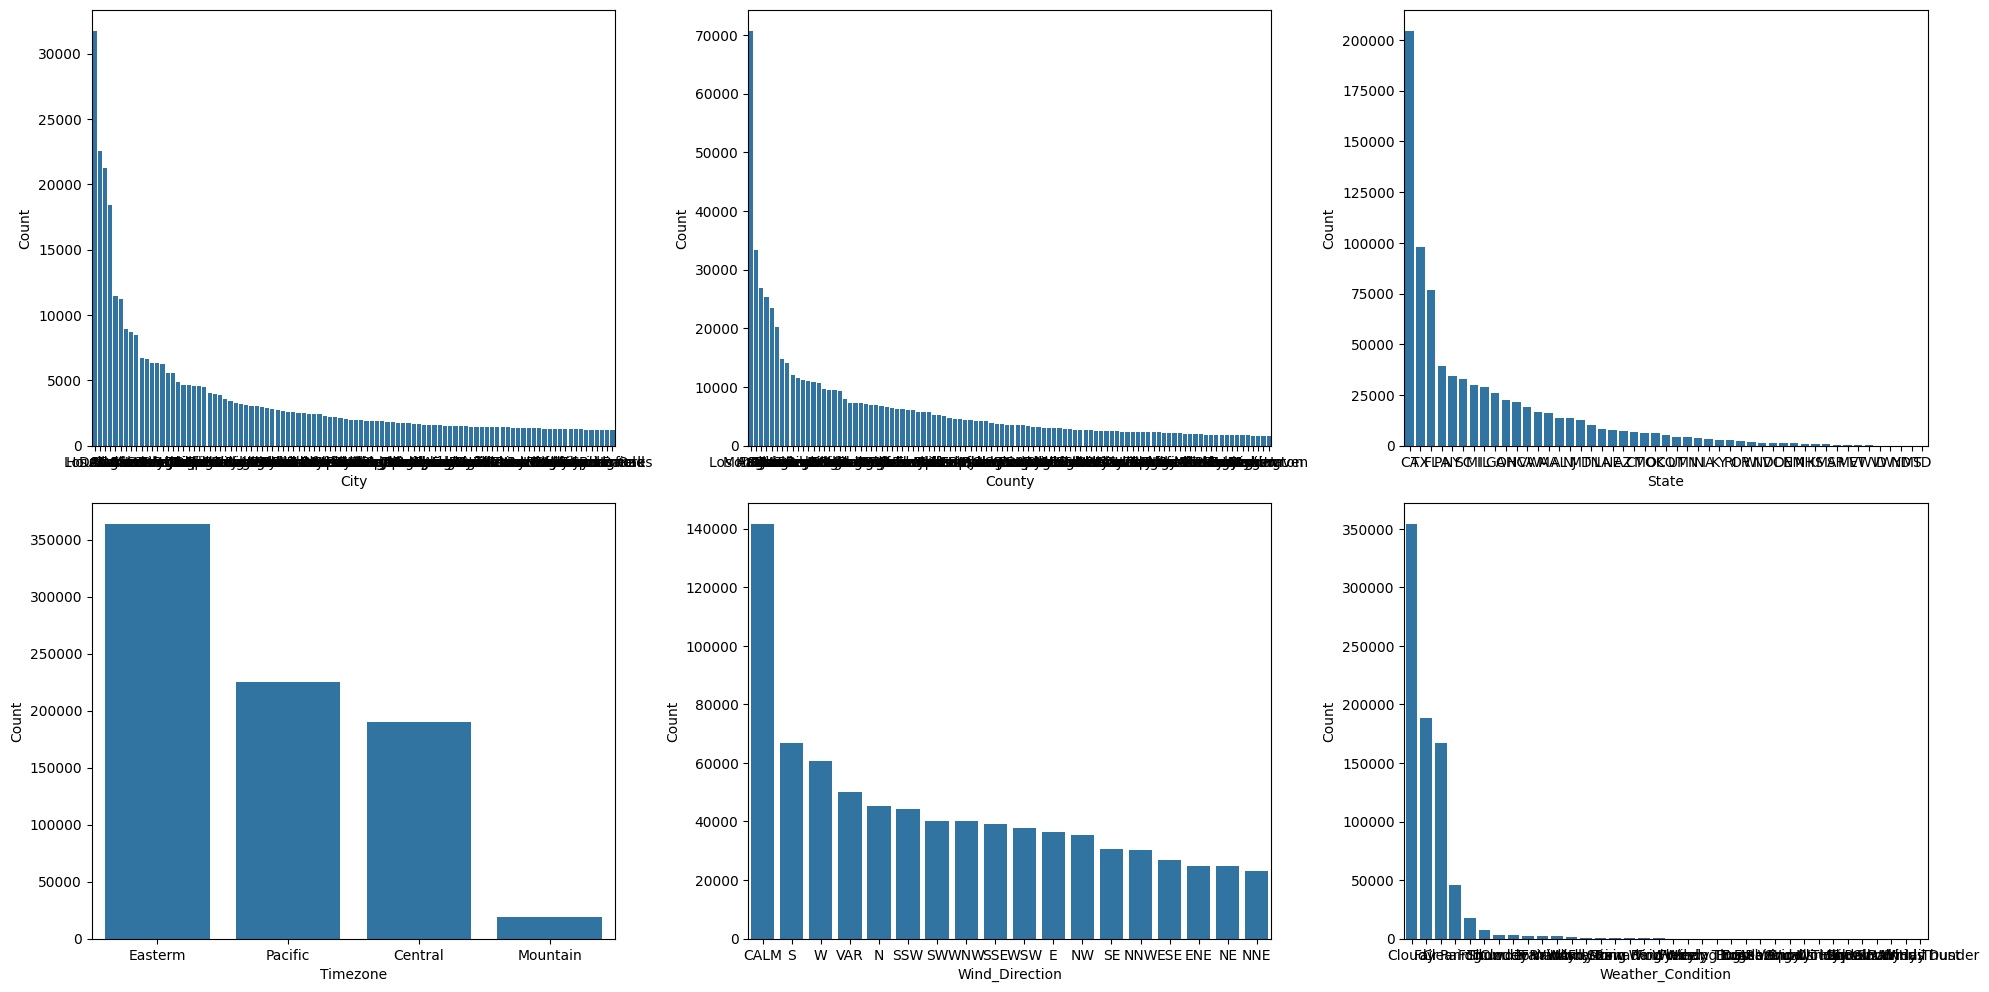

In [123]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes_flattened = axes.reshape(-1)

for idx, column in enumerate(cat_df.columns):
    ax = axes_flattened[idx]
    value_counts = df_train[column].value_counts()
    viz_df = pd.DataFrame({column: value_counts.index[:100], 'Count': value_counts.values[:100]})
    sns.barplot(
        x=column,
        y='Count',
        data=viz_df.dropna(),
        ax=ax
        )
    
fig.tight_layout(pad=1.0)

In [111]:
df_train.drop(columns=['Zipcode', 'Airport_Code', 'Description'], inplace=True)

In [112]:
df_train['Timezone'] = df_train['Timezone'].replace({
    "US/Eastern": "Easterm",
    "US/Central": "Central",
    "US/Pacific": "Pacific",
    "US/Mountain": "Mountain"
})

In [113]:
nan_df = (df_train.isnull().mean() * 100).reset_index()
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)
nan_df.head(10)

,column_name,percentage
14,Weather_Condition,1.813102
11,Wind_Direction,1.349701
2,Street,0.171760
6,Timezone,0.045003
3,City,0.003000
0,Severity,0.000000
36,End_Date_Day,0.000000
28,Lat,0.000000
29,Lng,0.000000
30,Start_Date_Year,0.000000


In [114]:
replacement_words = {
    "Ash": "Ash",
    "Browing": "Browing",
    "Cloud": "Cloudy",
    "Clouds": "Cloudy",
    "Cloudy": "Cloudy",
    "Drizzle": "Rain",
    "Dust": "Dust",
    "Duststorm": "Duststorm",
    "Fair": "Fair",
    "Fog": "Fog",
    "Freezing": "Freezing",
    "Funnel": "Cloudly",
    "Grains": "Hail",
    "Hail": "Hail",
    "Haze": "Fog",
    "Ice": "Ice",
    "Mist": "Fog",
    "Mix": "Mix",
    "Overcast": "Cloudy",
    "Rain": "Rain",
    "Sand": "Dust",
    "Shower": "Rain",
    "Showers": "Rain",
    "Sleet": "Snow",
    "Smoke": "Ash",
    "Snow": "Snow",
    "Squalls": "Squalls",
    "T-Storm": "Tornado",
    "Whirls": "Whirls",
    "Whirlwinds": "Whirls",
    "Windy": "Windy",
    "Wintry": "Snow",
    "Clear": "Clear",
    "Thunder": "Thunder",
    "Thunderstorm": "Thunder",
    "Thunderstorms": "Thunder",
}

In [115]:
df_train['Weather_Condition'] = df_train['Weather_Condition'].replace({"N/A": np.nan})

In [116]:
Processed_Weather_Condition = df_train.dropna()['Weather_Condition'].apply(
    lambda x: ' '.join(
        set(
            sorted(
                [
                    replacement_words[word] for word in x.split(" ") if word in replacement_words.keys()
                    ]
                )
            )
        ) if not x == np.nan else np.nan
    )
for index in Processed_Weather_Condition.index:
    if 'Mix' in Processed_Weather_Condition[index]:
        Processed_Weather_Condition[index] = 'Mix'
        
df_train['Weather_Condition'] = Processed_Weather_Condition 
        

In [117]:
df_train['Weather_Condition'] = df_train.groupby('Severity')['Weather_Condition'].transform(lambda x: x.fillna(x.mode()[0]))

! Количество слов где-то 31, количество классов 35 => OneHotEncoder не выгоден

In [118]:
df_train['Wind_Direction'] = df_train['Wind_Direction'].replace({'South': 'S',
                                                                 'West': 'W',
                                                                 'North': 'N',
                                                                 'Variable': 'VAR',
                                                                 'East': 'E',
                                                                 'Calm': 'CALM'
                                                                 })

In [119]:
df_train['Wind_Direction'].fillna('VAR', inplace=True)

In [120]:
df_train.dropna(inplace=True)

Почему выкидываем Street:
1) есть Штат, Округ, Координаты. Для нашей задачи этого достаточно
2) На необработанных слишком много классов
3) Слишком проблемно обрабатывать

In [121]:
df_train.drop(columns=['Street'], inplace=True)

It is necessary fix

In [126]:
df_train = pd.concat(
    [
        df_train,
        encoded_categorical_columns
    ]
)
df_train.drop(columns=['Timezone'], inplace=True)

In [78]:
df_train['Timezone_Central'].value_counts()

Timezone_Central
0.0    608197
1.0    190000
Name: count, dtype: int64

In [79]:
df_train.drop(columns=[0, 1, 2, 3], inplace = True)
df_train.columns

Index(['Severity', 'Distance(mi)', 'City', 'County', 'State', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Lat', 'Lng', 'Start_Date_Year', 'Start_Date_Month',
       'Start_Date_Day', 'Start_Date_Hour', 'End_Date_Year', 'End_Date_Month',
       'End_Date_Day', 'End_Date_Hour', 'Weather_Datestamp_Year',
       'Weather_Datestamp_Month', 'Weather_Datestamp_Day',
       'Weather_Datestamp_Hour', 'Time_Difference', 'Is_Day', 'Is_Civil_Day',
       'Is_Twilight_Day', 'Is_Astronomical_Day', 'Timezone_Central',
       'Timezone_Easterm', 'Timezone_Mountain', 'Timezone_Pacific'],
      dtype='object')

In [82]:
df_train['Bump']

760648    False
79333     False
771344    False
179102    False
75318     False
          ...  
963395      NaN
117952      NaN
435829      NaN
305711      NaN
985772      NaN
Name: Bump, Length: 2394591, dtype: object